[View in Colaboratory](https://colab.research.google.com/github/Vnulartex/NotationClassifier/blob/master/Note_pitches.ipynb)

In [1]:
!pip install music21

    100% |████████████████████████████████| 18.0MB 621kB/s 
  Running setup.py bdist_wheel for music21 ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/53/8b/a6/be1921c60a68f0bea31c6b6a0a7b125badd61294d6a694407f
Successfully built music21


In [0]:
from music21 import *
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import numpy as np
import random

In [0]:
pitchCount = {"C": 0, "D": 0, "E": 0, "F": 0, "G": 0, "A": 0, "B": 0}
def GetPitchCounts(pitches):
  for pitch in pitches:
    pitchCount[pitch.step]+= 1
  values = np.array(list(pitchCount.values()),dtype="float")
  values /= values.max()
  return values

In [4]:
numScores = 30
composerNames = ["bach", "trecento"]

scorePaths= [random.sample(corpus.getComposer(composer),numScores) for composer 
            in composerNames]
print(len(scorePaths))

2


In [0]:
composers=[]
composerPitches = []
for j,composer in enumerate(scorePaths):
  composerPitches = []
  for score in composer:
    score = corpus.parse(score)
    key = score.analyze("key")
    i = interval.Interval(key.tonic, note.Note('C').pitch)
    score = score.transpose(i)
    pitchCounts = GetPitchCounts(score.pitches)
#     pitchCounts.sort()
    composerPitches.append(pitchCounts)
  composers.append((j,composerPitches))

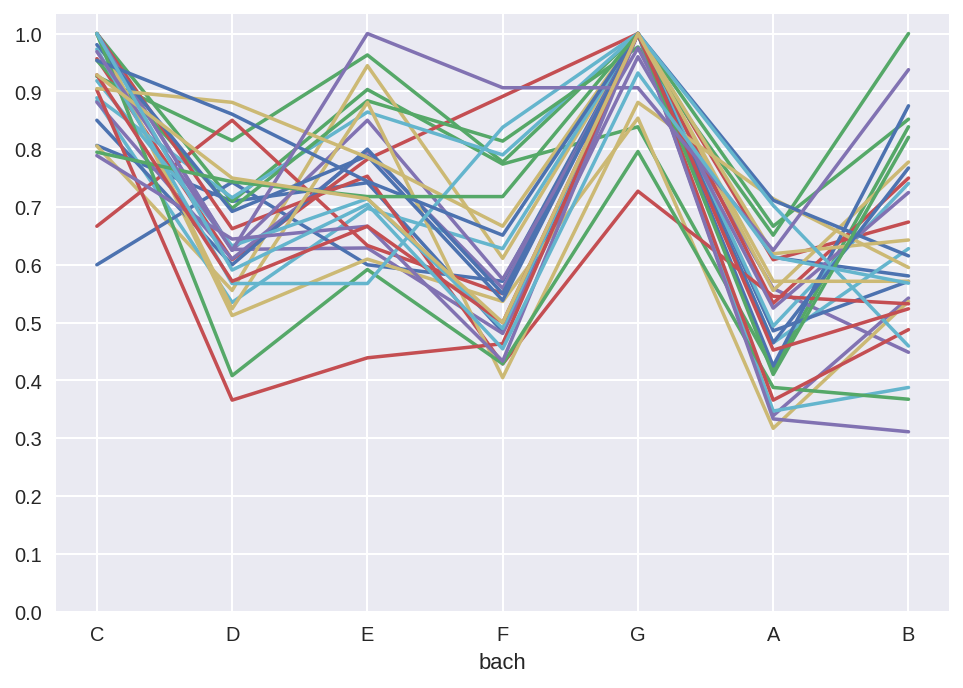

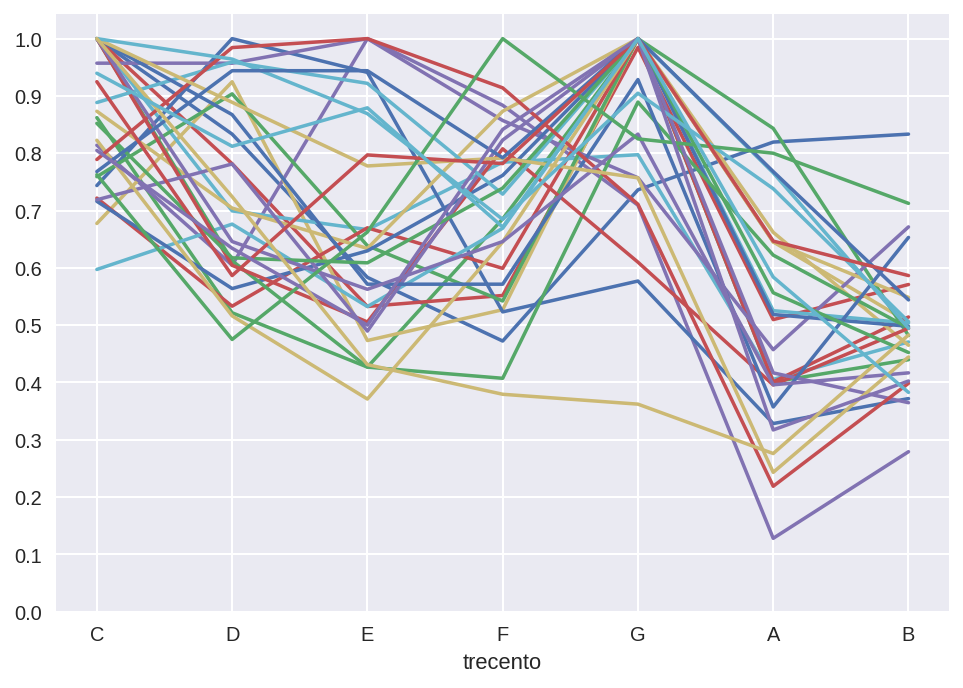

In [11]:
for composer in composers:
  label = composerNames[composer[0]]
  plt.xlabel(label)
  for score in composer[1]:
    plt.plot(score)
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.xticks(np.arange(7),pitchCount.keys())
  plt.show()

In [21]:
print(composers[0][1])

[array([0.80645161, 0.70967742, 0.74193548, 0.48387097, 1.        ,
       0.61290323, 0.58064516]), array([1.        , 0.70967742, 0.90322581, 0.77419355, 0.83870968,
       0.41935484, 0.83870968]), array([0.95652174, 0.60869565, 0.7826087 , 0.89130435, 1.        ,
       0.60869565, 0.67391304]), array([1.        , 0.62656642, 0.62907268, 0.48120301, 0.95989975,
       0.55889724, 0.44862155]), array([0.80555556, 0.55555556, 0.94444444, 0.61111111, 1.        ,
       0.55555556, 0.77777778]), array([0.88372093, 0.53488372, 0.69767442, 0.62790698, 1.        ,
       0.46511628, 0.62790698]), array([0.6       , 0.74285714, 0.6       , 0.57142857, 1.        ,
       0.48571429, 0.57142857]), array([0.92592593, 0.81481481, 0.96296296, 0.77777778, 1.        ,
       0.66666667, 0.85185185]), array([0.66666667, 0.85      , 0.63333333, 0.55      , 1.        ,
       0.53333333, 0.75      ]), array([0.88135593, 0.61016949, 0.79661017, 0.55932203, 1.        ,
       0.33898305, 0.54237288]),

In [0]:
split = numScores * 0.8
training_data = []
test_data = []
for composer in composers:
  y = composer[0]
  
  training_data.extend([(x,y) for x in composer[1][:20]])
  test_data.extend([(x,y) for x in composer[1][20:]])
random.shuffle(training_data)

In [34]:
x_train = [a[0] for a in training_data]
y_train = [a[1] for a in training_data]
x_test = [a[0] for a in test_data]
y_test = [a[1] for a in test_data]
print(test_data)

[(array([0.90243902, 0.36585366, 0.43902439, 0.46341463, 1.        ,
       0.36585366, 0.48780488]), 0), (array([0.78888889, 0.64444444, 0.66666667, 0.43333333, 1.        ,
       0.33333333, 0.31111111]), 0), (array([0.9047619 , 0.88095238, 0.78571429, 0.66666667, 1.        ,
       0.61904762, 0.64285714]), 0), (array([0.97297297, 0.56756757, 0.56756757, 0.83783784, 1.        ,
       0.7027027 , 0.45945946]), 0), (array([0.95348837, 0.86046512, 0.74418605, 0.65116279, 1.        ,
       0.46511628, 0.76744186]), 0), (array([0.79487179, 0.74358974, 0.71794872, 0.71794872, 1.        ,
       0.41025641, 0.82051282]), 0), (array([0.92857143, 0.57142857, 0.66666667, 0.5       , 1.        ,
       0.45238095, 0.52380952]), 0), (array([0.96875, 0.625  , 1.     , 0.90625, 0.90625, 0.625  , 0.9375 ]), 0), (array([0.92857143, 0.75      , 0.71428571, 0.5       , 1.        ,
       0.57142857, 0.57142857]), 0), (array([1.        , 0.59090909, 0.70454545, 0.45454545, 0.93181818,
       0.61363

In [32]:
print(len(composers[0][1]))

30


In [47]:
clf = SVC(kernel="sigmoid", probability = True, decision_function_shape = 'ovo')
clf.fit(x_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
clf.score(x_test,y_test)

0.85